# Implementing Yann LeCun's LeNet-5 in PyTorch

## Setup

In [15]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from collections import OrderedDict

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
%config InlineBackend.figure_format = 'retina'

In [17]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 5

IMG_SIZE = 32
N_CLASSES = 10

## Helper Functions

In [18]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(1, epochs+1):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

## Data

In [19]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [20]:
len(valid_dataset)

10000

In [21]:
len(train_dataset)

60000

**Plotting the images**

In [22]:
ROW_IMG = 5
N_ROWS = 2

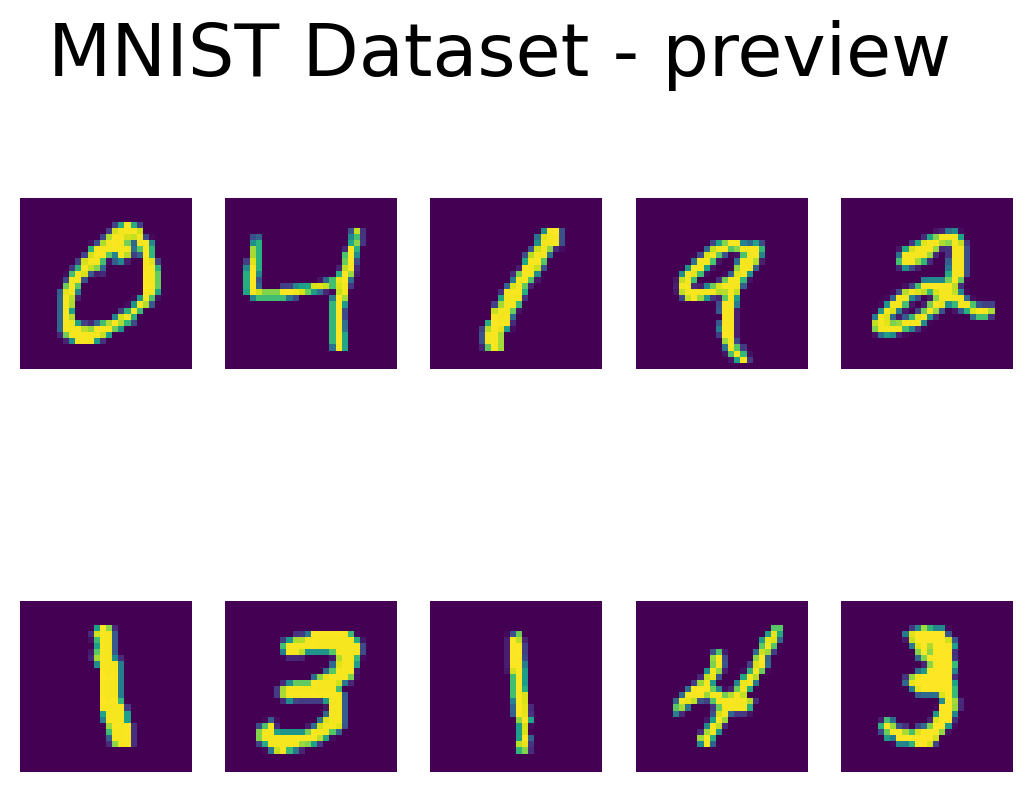

In [23]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

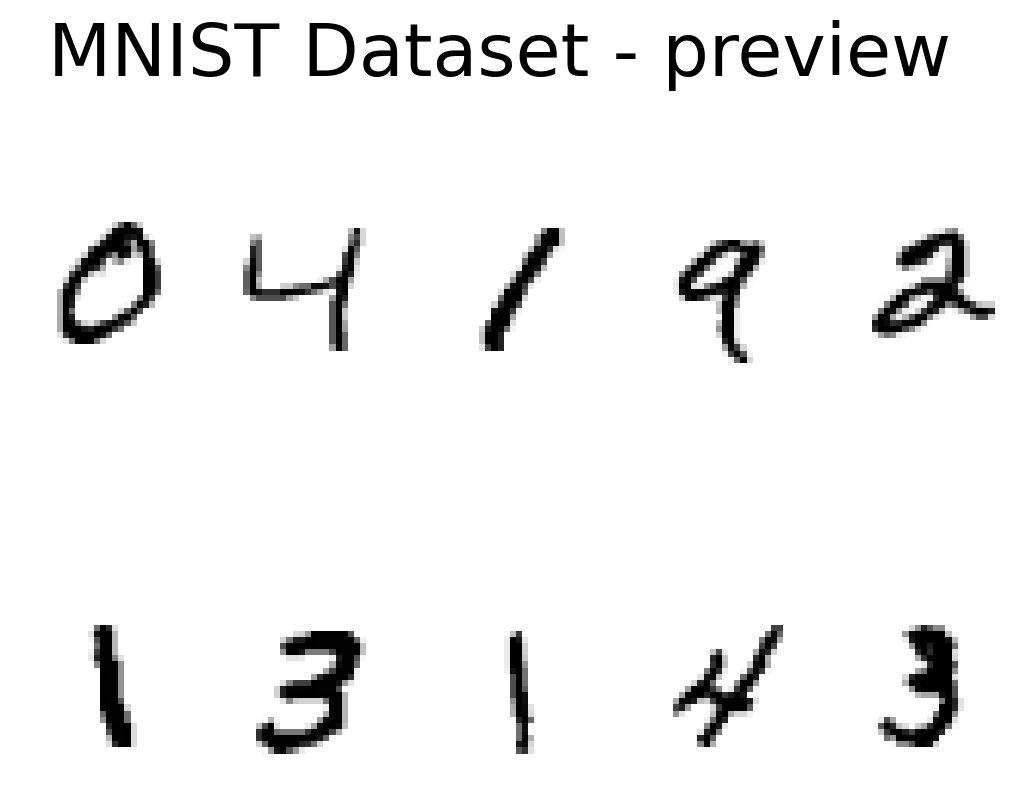

In [24]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

## Implementing LeNet-5

In [25]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(OrderedDict(
            [
                ('conv1',   nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)),
                ('tanh1',   nn.Tanh()),
                ('avpool1', nn.AvgPool2d(kernel_size=2)),
                ('conv2',   nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)),
                ('tanh2',   nn.Tanh()),
                ('avpool2', nn.AvgPool2d(kernel_size=2)),
                ('conv3',   nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)),
                ('tanh3',   nn.Tanh())
            ]))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [26]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [27]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

KeyboardInterrupt: 

**Evaluating the predictions**

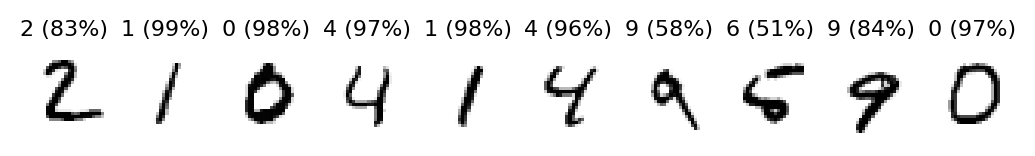

In [39]:
ROW_IMG = 10
N_ROWS = 1

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=8)
#fig.suptitle('LeNet-5 - predikce')

plt.savefig('./lenet_pred.png')

In [50]:
print(len(model.feature_extractor))

for i in range(0, len(model.feature_extractor)):
    if hasattr(model.feature_extractor[i], 'weight'):
        print(len(model.feature_extractor[i].weight))
    else:
        print('no attrib')

8
6
no attrib
no attrib
16
no attrib
no attrib
120
no attrib


In [51]:
for parameter in model.parameters():
    print(parameter)

Parameter containing:
tensor([[[[ 3.6063e-02,  2.4066e-01,  1.8210e-01,  3.4609e-01, -6.5183e-02],
          [ 9.1186e-02,  3.5664e-01,  6.9382e-01,  4.7723e-01, -1.3015e-01],
          [ 1.6794e-01,  3.0512e-01,  4.1882e-01,  1.0515e-01, -1.9863e-02],
          [-2.0502e-01,  9.5376e-02, -5.7230e-02, -2.6509e-01, -2.0110e-01],
          [-4.1478e-01, -3.0071e-01, -3.7326e-01, -1.6288e-01, -4.2615e-01]]],


        [[[-2.6256e-01, -2.4802e-01, -3.2997e-01, -1.9864e-01, -4.3131e-01],
          [ 1.6985e-01, -2.0935e-01,  9.2085e-02, -2.4075e-02, -1.2749e-01],
          [ 3.6828e-01,  2.8207e-01,  3.9473e-01,  2.3599e-01,  9.5626e-02],
          [ 4.3864e-01,  4.0212e-01,  5.2797e-01,  5.3231e-01,  3.4687e-01],
          [ 8.3539e-02,  2.7486e-01,  1.5227e-01,  2.0065e-01, -5.6848e-02]]],


        [[[-1.9016e-01,  4.8622e-02,  8.2005e-02,  4.6471e-01,  3.6483e-01],
          [ 8.6858e-02,  2.2394e-01,  2.2800e-01,  3.1869e-01, -7.3623e-02],
          [ 3.3151e-02, -1.7763e-02,  9.1409e-

In [52]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

get_n_params(model)

61706